In [82]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, TwoModels, ClassTransformation
from catboost import CatBoostClassifier

In [83]:
# Загружаем данные
df = pd.read_csv('data.csv')
# Переименовываем признаки
df.rename(columns = {'conversion':'target', 'offer':'treatment'}, inplace = True)
# Приводим признак к бинарному виду
df['treatment'] = df['treatment'].map({'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0})
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


In [84]:
# Добавляем новый признак категорию по лояльности. 0, если вообще не использует никакие программы,
# 1 одну из, 2 если использует все возможные программы лояльности.
def loyalty_encoder(df):
    df['loyalty_category'] = 1
    df.loc[(df.used_discount == 1) & (df.used_bogo == 1), 'loyalty_category'] = 2
    df.loc[(df.used_discount == 0) & (df.used_bogo == 0), 'loyalty_category'] = 0
    return df
# Добавляем новую категорию по лояльности
df = loyalty_encoder(df)
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,loyalty_category
0,10,142.44,1,0,Surburban,0,Phone,1,0,1
1,6,329.08,1,1,Rural,1,Web,0,0,2
2,7,180.65,0,1,Surburban,1,Web,1,0,1


In [85]:
# Бьем на треин тест
train, test = train_test_split(df, test_size=0.3, random_state=42)
# Делаем данные для обучения
y_train = train.loc[train.index, 'target']
treat_train = train.loc[train.index, 'treatment']
train_features = train.drop(['target', 'treatment'], axis=1)
# То же самое нам нужно для теста
y_test = test.loc[test.index, 'target']
treat_test = test.loc[test.index, 'treatment']
test_features = test.drop(['target', 'treatment'], axis=1)

In [86]:
# Обозначим категориальные признаки
cat_features = ['zip_code', 'channel']
# Подготовим словарь под результаты
models_results = {
    'model': [],
    'uplift@10%': [],
    'uplift@20%': []
}
# В следующих ячейках уже обучаем модели

uplift@10%: 0.1105
uplift@20%: 0.1018


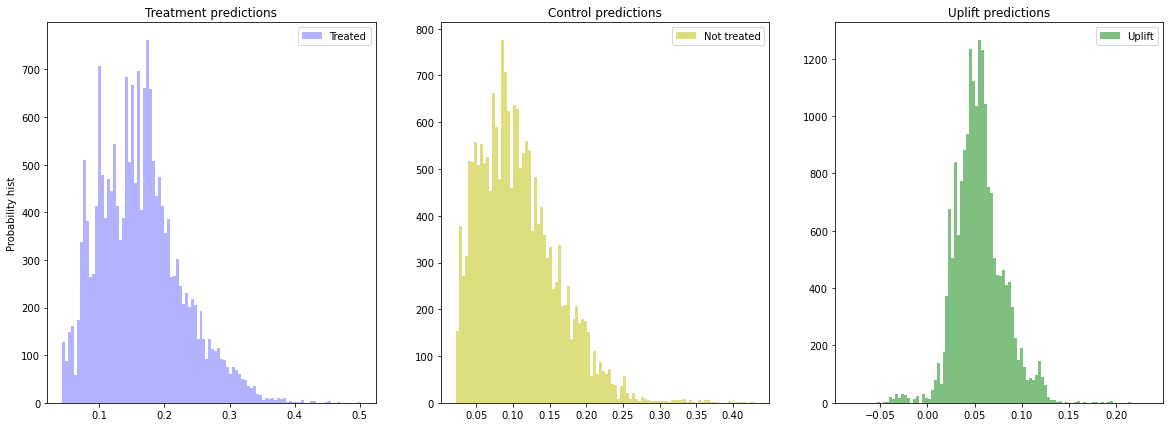

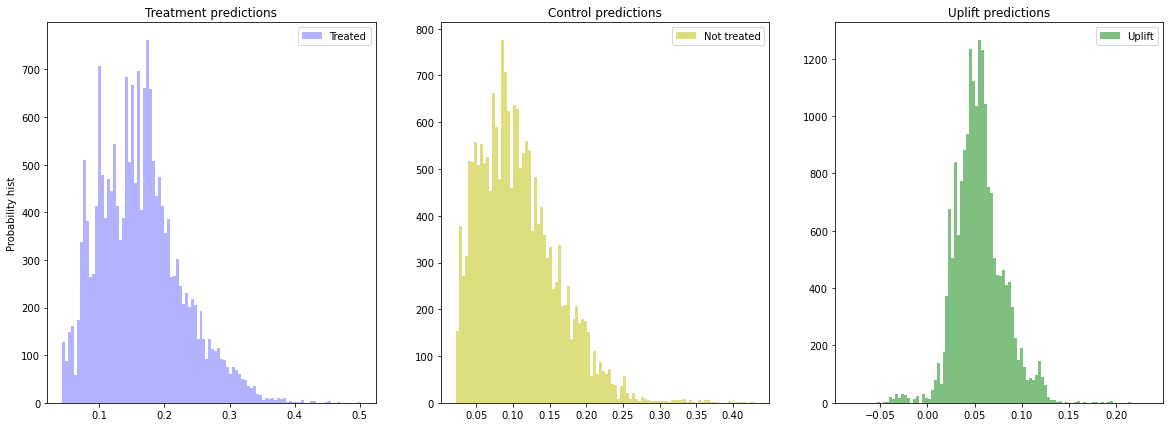

In [87]:
# Соло модель
models_results['model'].append('SoloModel')

k = [0.1, 0.2]

for el in k:    
    sm = SoloModel(CatBoostClassifier(iterations=30, random_state=42, silent=True, cat_features=cat_features))
    sm = sm.fit(train_features, y_train, treat_train)
    uplift_sm = sm.predict(test_features)
    
    sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=el) 
    
    if el == 0.1:   
        print(f'uplift@10%: {sm_score:.4f}')
        models_results['uplift@10%'].append(sm_score)
    elif el == 0.2:
        print(f'uplift@20%: {sm_score:.4f}')
        models_results['uplift@20%'].append(sm_score)

    # Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
    sm_trmnt_preds = sm.trmnt_preds_
    # И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
    sm_ctrl_preds = sm.ctrl_preds_

    # Отрисуем распределения вероятностей и их разность (uplift)
    plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [88]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,20.929777
1,treatment,19.542811
2,recency,14.317781
3,zip_code,11.320209
4,history,10.185872
5,channel,9.895309
6,loyalty_category,8.759547
7,used_bogo,3.305105
8,used_discount,1.743589


In [89]:
# Трансформация классов
models_results['model'].append('ClassTransformation')
ct = ClassTransformation(CatBoostClassifier(iterations=30, random_state=42, silent=True, cat_features=cat_features))
ct = ct.fit(train_features, y_train, treat_train)
uplift_ct = ct.predict(test_features)

for el in k:
    ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=el)
    
    if el == 0.1:   
        print(f'uplift@10%: {ct_score:.4f}')
        models_results['uplift@10%'].append(ct_score)
    elif el == 0.2:
        print(f'uplift@20%: {ct_score:.4f}')
        models_results['uplift@20%'].append(ct_score)

uplift@10%: 0.1058
uplift@20%: 0.0976


uplift@10%: 0.0916
uplift@20%: 0.0935


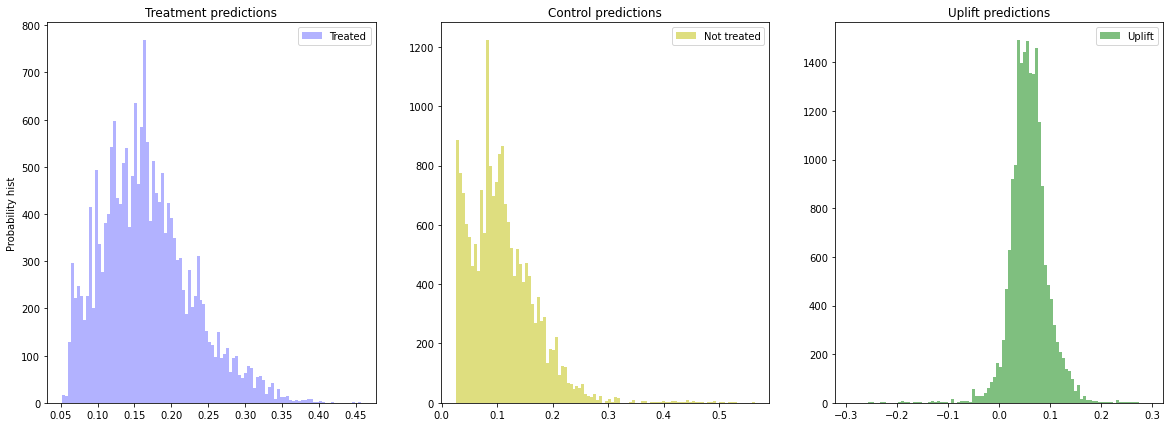

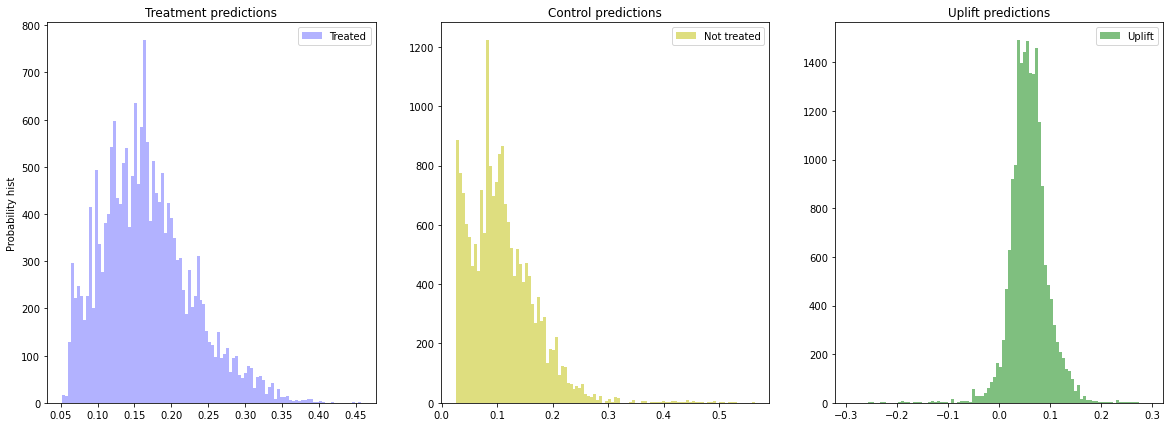

In [90]:
# Две независимые модели
tm = TwoModels(
    CatBoostClassifier(iterations=30, random_state=42, silent=True, cat_features=cat_features),
    CatBoostClassifier(iterations=30, random_state=42, silent=True, cat_features=cat_features),
    method='vanilla'  # независимые модели
)
tm = tm.fit(train_features, y_train, treat_train)

uplift_tm = tm.predict(test_features)
models_results['model'].append('TwoModels')
for el in k:
    
    tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=el)

    if el == 0.1:   
        print(f'uplift@10%: {tm_score:.4f}')
        models_results['uplift@10%'].append(tm_score)
    elif el == 0.2:
        print(f'uplift@20%: {tm_score:.4f}')
        models_results['uplift@20%'].append(tm_score)
        
    # Отрисуем распределения вероятностей и их разность (uplift)    
    plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [92]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,model,uplift@10%,uplift@20%
0,SoloModel,0.110469,0.101803
1,ClassTransformation,0.105847,0.097598
2,TwoModels,0.091589,0.093512


SoloModel оказалась самой оптимальной, а с 2 моделями хуже всех отработало. Странно..